<a href="https://colab.research.google.com/github/sijixx/WhatsApp-Chat-Analysis/blob/main/WhatsApp_Chat_Analysis_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Brief introduction to the whatsapp messenger chat analysis

WhatsApp is an everyday tool for interactions with other people. With over 2 Billion users around the world WhatsApp has become a part of our daily lives. It can be a source of income, networking and an everyday work tool. So chances are that most of the people you know, work with or do some sort of business with use WhatsApp. But then to fully maximise the use of WhatsApp it is important to know how to interact with the WhatsApp messenger and also know how to use it to your full advantage and get productive with it.

I decided to do this project because I can use my own generated data and not some data off the internet.

In this project i will be using Python to analyse some of my WhatsApp chats.


# **What I plan to achieve with this project.**

1.   Understand how to export or download chat data from WhatsApp messenger in TXT format and convert to a structured dataframe.
2.   Preprocess the data gotten and use it to perform some analysis. Some of these analysis are: 

      *   How often people drop messages on the group chat.
      *   Most active member of the group.
      *   Inactive members of the group.
      *   Average words used per messages
      *   Total messages sent
      *   Most active time of the day, day of the week etc.
      *   Most used emoji
      *   Most active day(s) of messaging
      *   Most used word visualised in a wordcloud. And more that comes to me 
          as I go on in the project.
  
3. Visulaize Data using seaborn and Matplotlib.
4. Give myself some recommendations on how to better engage the group.

**This project is aimed to help me better understand Data Analysis using Python.**


# Let's go!!





In [18]:
#import all needed liberaries
!pip install emoji
import datetime
import numpy as np
import pandas as pd #this is for dataframe manipulation
import matplotlib.pyplot as plt
import seaborn as sns #These are for data visualization


from wordcloud import WordCloud, STOPWORDS
import re #Regular expressions, this is used to manipulate strings
from collections import Counter

import warnings
warnings.filterwarnings('ignore') #This is to avoid unneccesary warnings from being displayed

%matplotlib inline

**Importing the chat data.**

*   When I exported the group chat dat from WhatsApp, It's displayed line by line i.e you will have to read the messages line by line to get the information you need... Having to analyse these information we need to find a way to identify messages from different members of the group and also find a way to know if the next line of messages is part of the previously sent message or if it's a new message form a differnt member.
*   In order to do this we need to use the split() function when reading each line od messages. First item is a valid date which is returned from the split() function and time is also returned and each is split into columns. If the start of the next line is not a valid date/time then the message will be appened to the previous message.

***The code was gotten from MrBriit ***

In [34]:
from google.colab import files
uploaded = files.upload()

Saving WhatsAppchat.txt to WhatsAppchat.txt


In [27]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    return df

In [37]:
'''Now lets convert the whatsapp chat txt file to dataframe'''
df = rawToDf('WhatsAppchat.txt', '24hr')
df

,date_time,user,message
0,2020-07-02 18:54:00,group_notification,Messages and calls are end-to-end encrypted. N...
1,2020-07-02 18:54:00,Matketfaith.Online,Good evening sir
2,2020-07-02 18:54:00,Matketfaith.Online,Happy new month sir
3,2020-07-02 18:55:00,Matketfaith.Online,Thank you for the prayer session yesterday sir...
4,2020-07-02 19:01:00,Pastor Deji Agboade,Hey Debo how now?
...,...,...,...
4346,2021-12-09 15:13:00,Pastor Deji Agboade,Ok
4347,2021-12-09 15:13:00,Pastor Deji Agboade,The video is dark
4348,2021-12-09 15:13:00,Pastor Deji Agboade,"Going forward, the light can't be so close to ..."
4349,2021-12-09 15:17:00,Matketfaith.Online,Ok sir


The date_time column is intepreted as a string, python does not recognize this as a date or time value but instead just a bunch of words. so what we will do is change that by converting that string into what python can easily recognise, we will be creating new columns for the date, time when message was sent, the day of the week and also the year.

In [39]:
df['user'].unique()

array(['group_notification', 'Matketfaith.Online', 'Pastor Deji Agboade'],
      dtype=object)

In [41]:
'''Now let us add new data to what we already have, we will be adding the Day, Month, Year and Date. This will allow us further analyse'''

df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())
df

,date_time,user,message,day,month,year,date
0,2020-07-02 18:54:00,group_notification,Messages and calls are end-to-end encrypted. N...,Thu,Jul,2020,2020-07-02
1,2020-07-02 18:54:00,Matketfaith.Online,Good evening sir,Thu,Jul,2020,2020-07-02
2,2020-07-02 18:54:00,Matketfaith.Online,Happy new month sir,Thu,Jul,2020,2020-07-02
3,2020-07-02 18:55:00,Matketfaith.Online,Thank you for the prayer session yesterday sir...,Thu,Jul,2020,2020-07-02
4,2020-07-02 19:01:00,Pastor Deji Agboade,Hey Debo how now?,Thu,Jul,2020,2020-07-02
...,...,...,...,...,...,...,...
4346,2021-12-09 15:13:00,Pastor Deji Agboade,Ok,Thu,Dec,2021,2021-12-09
4347,2021-12-09 15:13:00,Pastor Deji Agboade,The video is dark,Thu,Dec,2021,2021-12-09
4348,2021-12-09 15:13:00,Pastor Deji Agboade,"Going forward, the light can't be so close to ...",Thu,Dec,2021,2021-12-09
4349,2021-12-09 15:17:00,Matketfaith.Online,Ok sir,Thu,Dec,2021,2021-12-09


In [43]:
df.isnull().sum()

date_time    0
user         0
message      0
day          0
month        0
year         0
date         0
dtype: int64

Now we start with the analysis, our data has been processed and is ready to analysed... We start by checking the frequency of messages sent.

The first thing we do is to do a message count and then we group the messages by the sender. We can the visualise the frequency of messages sent on a monthly bases.

In [52]:
#I want to create a  copy of the dataframe, this is because i don't want to have to start all over again if i mess u the original dataframe

n_df = df.copy()
#After creating a new copy of the dataframe, we want to create a new column called message count, this allows us to allocated a number to each messages so that when i pick a person's number i can correctly count the number of messages the person has sent.

n_df['message count'] = n_df.shape[0]*[1]
n_df

,date_time,user,message,day,month,year,date,message count
0,2020-07-02 18:54:00,group_notification,Messages and calls are end-to-end encrypted. N...,Thu,Jul,2020,2020-07-02,1
1,2020-07-02 18:54:00,Matketfaith.Online,Good evening sir,Thu,Jul,2020,2020-07-02,1
2,2020-07-02 18:54:00,Matketfaith.Online,Happy new month sir,Thu,Jul,2020,2020-07-02,1
3,2020-07-02 18:55:00,Matketfaith.Online,Thank you for the prayer session yesterday sir...,Thu,Jul,2020,2020-07-02,1
4,2020-07-02 19:01:00,Pastor Deji Agboade,Hey Debo how now?,Thu,Jul,2020,2020-07-02,1
...,...,...,...,...,...,...,...,...
4346,2021-12-09 15:13:00,Pastor Deji Agboade,Ok,Thu,Dec,2021,2021-12-09,1
4347,2021-12-09 15:13:00,Pastor Deji Agboade,The video is dark,Thu,Dec,2021,2021-12-09,1
4348,2021-12-09 15:13:00,Pastor Deji Agboade,"Going forward, the light can't be so close to ...",Thu,Dec,2021,2021-12-09,1
4349,2021-12-09 15:17:00,Matketfaith.Online,Ok sir,Thu,Dec,2021,2021-12-09,1


In [54]:
n_df = n_df.groupby('month').sum().reset_index() #Let's group by month this allows us to see the frequency of messages sent on a monthly basis!
n_df

,month,year,message count
0,Apr,2083651,1031
1,Aug,567894,281
2,Dec,50525,25
3,Jul,1455110,720
4,Jun,1851236,916
5,May,2362549,1169
6,Nov,68714,34
7,Oct,165722,82
8,Sep,187953,93


In [55]:
n_df.drop(columns= 'year',inplace = True) #Python sees the year values as numbers and not strings, hence the reason it added up all the year data values. so really don't need it anyway so wedrop the year column.
n_df

,month,message count
0,Apr,1031
1,Aug,281
2,Dec,25
3,Jul,720
4,Jun,916
5,May,1169
6,Nov,34
7,Oct,82
8,Sep,93


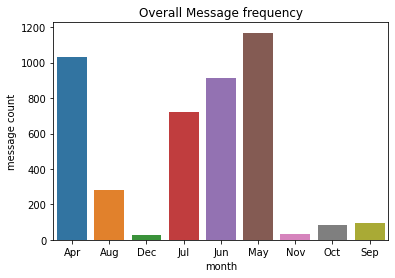

In [56]:
plt.title('Overall Message frequency')
sns.barplot(data=n_df, x='month', y='message count')

In [65]:
dff = df.copy()

dff['message count'] = dff.shape[0]*[1]
dff
#I created a new copy of the dataframe and did a message count again because i found out that analysing the frequency of messages on a monthly basis doen't really tell much.

,date_time,user,message,day,month,year,date,message count
0,2020-07-02 18:54:00,group_notification,Messages and calls are end-to-end encrypted. N...,Thu,Jul,2020,2020-07-02,1
1,2020-07-02 18:54:00,Matketfaith.Online,Good evening sir,Thu,Jul,2020,2020-07-02,1
2,2020-07-02 18:54:00,Matketfaith.Online,Happy new month sir,Thu,Jul,2020,2020-07-02,1
3,2020-07-02 18:55:00,Matketfaith.Online,Thank you for the prayer session yesterday sir...,Thu,Jul,2020,2020-07-02,1
4,2020-07-02 19:01:00,Pastor Deji Agboade,Hey Debo how now?,Thu,Jul,2020,2020-07-02,1
...,...,...,...,...,...,...,...,...
4346,2021-12-09 15:13:00,Pastor Deji Agboade,Ok,Thu,Dec,2021,2021-12-09,1
4347,2021-12-09 15:13:00,Pastor Deji Agboade,The video is dark,Thu,Dec,2021,2021-12-09,1
4348,2021-12-09 15:13:00,Pastor Deji Agboade,"Going forward, the light can't be so close to ...",Thu,Dec,2021,2021-12-09,1
4349,2021-12-09 15:17:00,Matketfaith.Online,Ok sir,Thu,Dec,2021,2021-12-09,1


In [67]:
dff = dff.groupby('date').sum().reset_index() #grouping by date, this plot is of frequency of messages / day.
dff

,date,year,message count
0,2020-07-02,20200,10
1,2020-08-04,14140,7
2,2021-04-05,40420,20
3,2021-04-06,34357,17
4,2021-04-07,97008,48
...,...,...,...
178,2021-12-02,12126,6
179,2021-12-06,18189,9
180,2021-12-08,6063,3
181,2021-12-09,12126,6


In [98]:
dff.sort_values(by= 'message count', ascending=False)
dff.reset_index(inplace=True) 
dff.drop(columns="index", inplace=True)
dff

#let's drop the year since we don't need it for anything, what we need is only the date and message count for our analysis.

,date,message count
0,2020-07-02,10
1,2020-08-04,7
2,2021-04-05,20
3,2021-04-06,17
4,2021-04-07,48
...,...,...
178,2021-12-02,6
179,2021-12-06,9
180,2021-12-08,3
181,2021-12-09,6


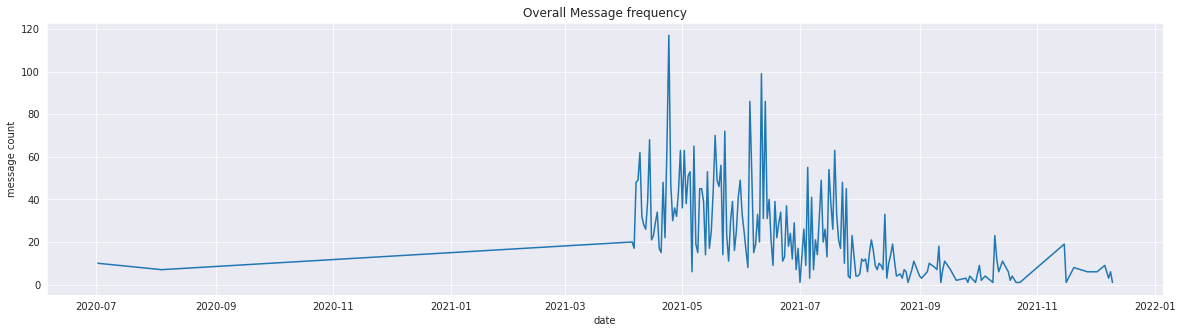

In [96]:
sns.set_style("darkgrid")
plt.figure(figsize= (20,5))
plt.title('Overall Message frequency')
sns.lineplot(data = dff, x='date', y='message count')

We can see here that there were very low interections seen in this group for over 7 months period. After which we can see some level of interactions for a period and also a steady decline in communications in the group.

In [90]:
top10msgdays = dff.sort_values(by="message count", ascending=False).head(10)#This will Sort values according to the number of messages per day.
top10msgdays.reset_index(inplace=True) 
top10msgdays.drop(columns="index", inplace=True)
top10msgdays

,date,message count
0,2021-04-24,117
1,2021-06-11,99
2,2021-06-13,86
3,2021-06-05,86
4,2021-05-23,72
5,2021-05-18,70
6,2021-04-14,68
7,2021-05-07,65
8,2021-04-23,64
9,2021-07-19,63


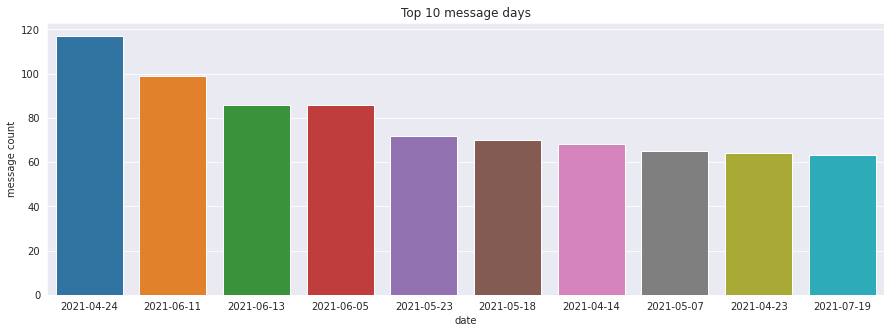

In [93]:
sns.set_style("darkgrid")
plt.figure(figsize= (15, 5))
plt.title('Top 10 message days')
sns.barplot(data=top10msgdays, x='date', y='message count') #this is a bar plot for top 10 days

In [99]:
#This is to get the most active users or top interative people in the group.
dff2 = df.copy()

dff2 = dff2[dff2.user != "group_notification"]
top10users = dff2.groupby("user")["message"].count().sort_values(ascending=False)

top10users = top10users.head(10).reset_index()
top10users

,user,message
0,Pastor Deji Agboade,2327
1,Matketfaith.Online,2023


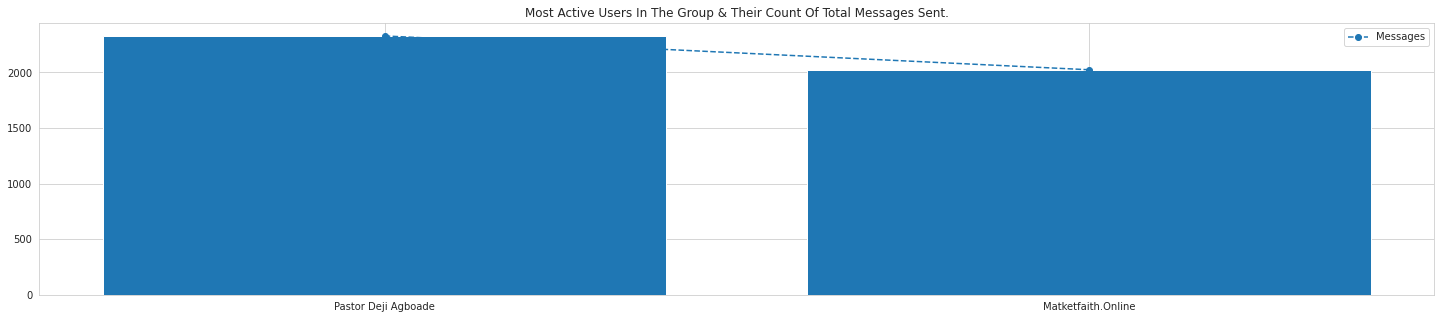

In [108]:
#This helps with improving the default styles in seaborn
sns.set_style("whitegrid")

# This help with increasing the figure size
plt.figure(figsize=(25, 5))


plt.title("Most Active Users In The Group & Their Count Of Total Messages Sent.")

plt.bar(top10users.user, top10users.message)   #The basic bar chart as represented
plt.plot(top10users.user, top10users.message, marker='o', ls='--')  #the line chart as represented
plt.legend(['Messages']);
plt.show()

In [110]:
#This is to get the least active users or least interative people in the group.
dff2 = df.copy()#create a copy of the data

dff2 = dff2[dff2.user != "group_notification"] #we don't want the group notifications appearing
leastusers = dff2.groupby("user")["message"].count().sort_values(ascending=True)

leastusers = leastusers.head(10).reset_index()
leastusers

,user,message
0,Matketfaith.Online,2023
1,Pastor Deji Agboade,2327


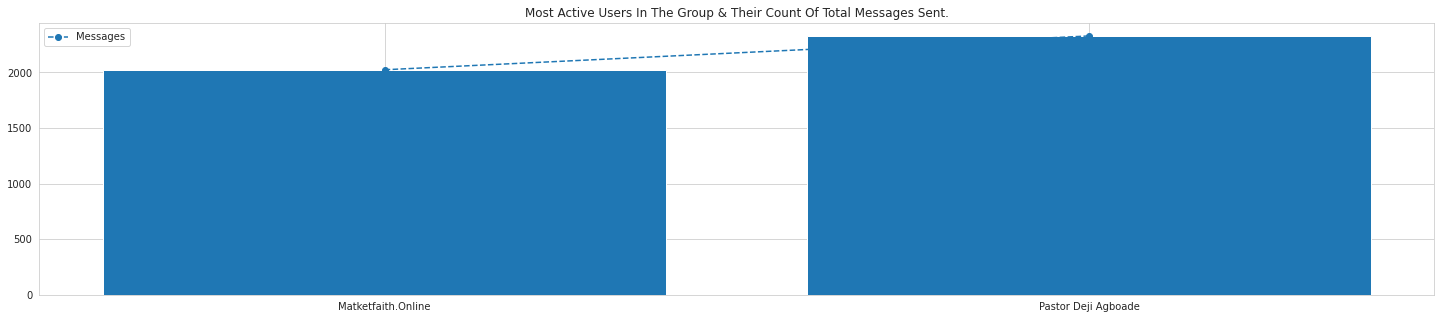

In [111]:
#This helps with improving the default styles in seaborn
sns.set_style("whitegrid")

#This help with increasing the figure size
plt.figure(figsize=(25, 5))


plt.title("Most Active Users In The Group & Their Count Of Total Messages Sent.")

plt.bar(leastusers.user, leastusers.message)   #the basic bar chart as represented
plt.legend(['Messages']);
plt.show()

In [112]:
df[df.message == '<Media omitted> ']#we exported the chat file without the media but to get the frequency of media sent by the users we need to curate the frequency of media omitted by each numbers or user.

,date_time,user,message,day,month,year,date
24,2021-04-05 18:07:00,Matketfaith.Online,<Media omitted>,Mon,Apr,2021,2021-04-05
42,2021-04-06 07:40:00,Matketfaith.Online,<Media omitted>,Tue,Apr,2021,2021-04-06
55,2021-04-07 06:22:00,Matketfaith.Online,<Media omitted>,Wed,Apr,2021,2021-04-07
67,2021-04-07 06:49:00,Matketfaith.Online,<Media omitted>,Wed,Apr,2021,2021-04-07
73,2021-04-07 06:57:00,Matketfaith.Online,<Media omitted>,Wed,Apr,2021,2021-04-07
...,...,...,...,...,...,...,...
4312,2021-11-20 14:29:00,Matketfaith.Online,<Media omitted>,Sat,Nov,2021,2021-11-20
4313,2021-11-20 14:30:00,Matketfaith.Online,<Media omitted>,Sat,Nov,2021,2021-11-20
4321,2021-11-27 14:03:00,Matketfaith.Online,<Media omitted>,Sat,Nov,2021,2021-11-27
4322,2021-11-27 14:04:00,Matketfaith.Online,<Media omitted>,Sat,Nov,2021,2021-11-27


In [114]:
#Using `groupby`, `count` and `sort_values` attributes.
top10mediasent = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

#This is for dropping unused columns
top10mediasent.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

#Renaming column name for visualization
top10mediasent.rename(columns={"message": "media_sent"}, inplace=True)

#resetting the index
top10mediasent.reset_index(inplace=True)

top10mediasent

,user,media_sent
0,Matketfaith.Online,473
1,Pastor Deji Agboade,59


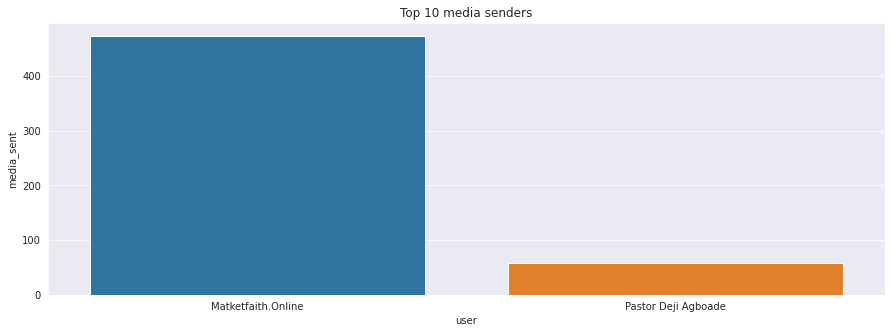

In [116]:
#This helps with improving the default styles in seaborn
sns.set_style("darkgrid")

plt.figure(figsize= (15, 5)) #This help with increasing the figure size

plt.title('Top 10 media senders')
sns.barplot(data=top10mediasent, x='user', y='media_sent')#Basic barchart as represented 

In [118]:
#This is get the most active hour of interactions in the group
dff3 = df.copy()
dff3['message_count'] = [1] * df.shape[0]    # this new column that will keep count.
 
dff3['hour'] = dff3['date_time'].apply(lambda x: x.hour)
 
grouped_by_time = dff3.groupby('hour').sum().reset_index().sort_values(by = 'hour')
grouped_by_time 

,hour,year,message_count
0,0,161680,80
1,1,80840,40
2,2,52546,26
3,3,30315,15
4,4,80840,40
5,5,189974,94
6,6,1042836,516
7,7,636615,315
8,8,254646,126
9,9,185932,92


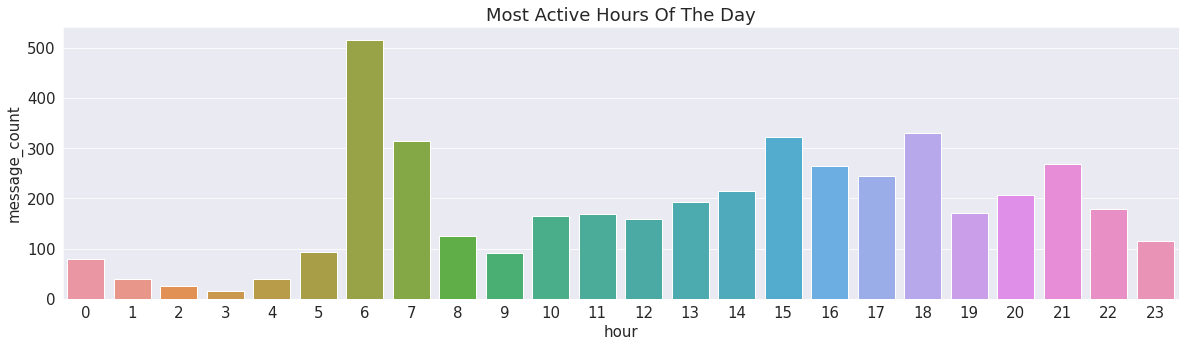

In [119]:
import matplotlib
matplotlib.rcParams['font.size'] = 15 #font size of the chart
matplotlib.rcParams['figure.figsize'] = (20, 5) #height and width of the chart

#Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

#PLOT: grouped by hour
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Most Active Hours Of The Day');

Here we see that the most interactive hour of the day are 6-7am in the morning and 3-6pm in the afternoon.

In [121]:
 #Most active day of the week
grouped_by_day = dff3.groupby('day').sum().reset_index()[['day', 'message_count']]
grouped_by_day 

,day,message_count
0,Fri,734
1,Mon,671
2,Sat,651
3,Sun,695
4,Thu,434
5,Tue,525
6,Wed,641


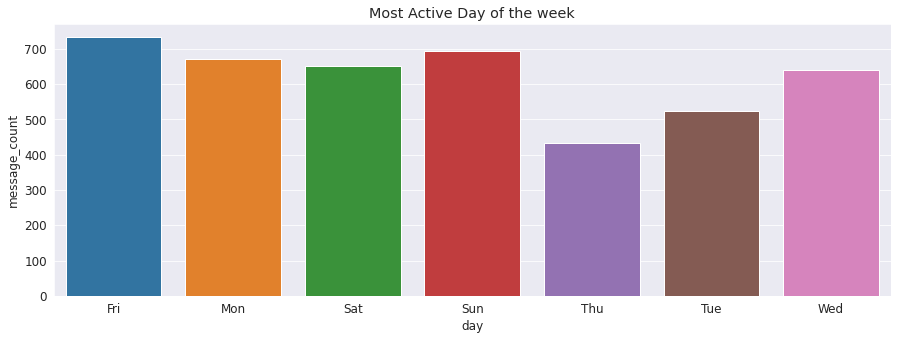

In [124]:
import matplotlib
matplotlib.rcParams['font.size'] = 12  #font size of the chart
matplotlib.rcParams['figure.figsize'] = (15, 5)#height and width of the chart

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(grouped_by_day.day, grouped_by_time.message_count)
plt.title('Most Active Day of the week');

In [129]:
#grouping by month;
grouped_by_month = dff3.groupby('month').sum().reset_index()[['month', 'message_count']]
grouped_by_month 

,month,message_count
0,Apr,1031
1,Aug,281
2,Dec,25
3,Jul,720
4,Jun,916
5,May,1169
6,Nov,34
7,Oct,82
8,Sep,93


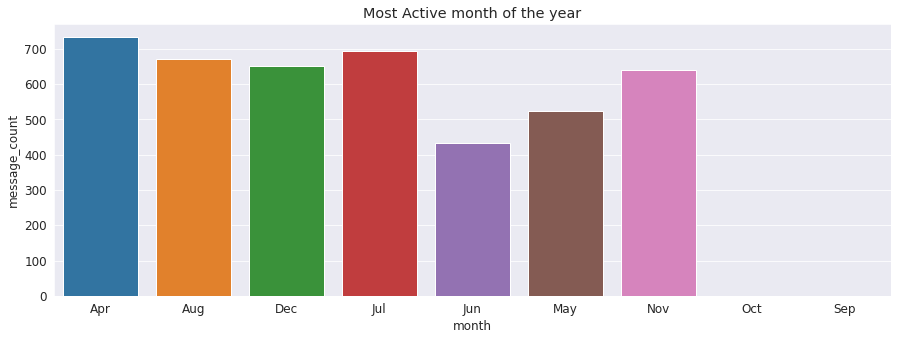

In [130]:
import matplotlib
matplotlib.rcParams['font.size'] = 12 #font size of the chart
matplotlib.rcParams['figure.figsize'] = (15, 5) #height and width of the chart

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

#PLOT: grouped by hour
sns.barplot(grouped_by_month.month, grouped_by_time.message_count)
plt.title('Most Active month of the year');

In [132]:
#Geting the most common words used and visualizing in a wordcloud
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
# stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined','join', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in dff3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white',  
                min_font_size = 8).generate(comment_words)

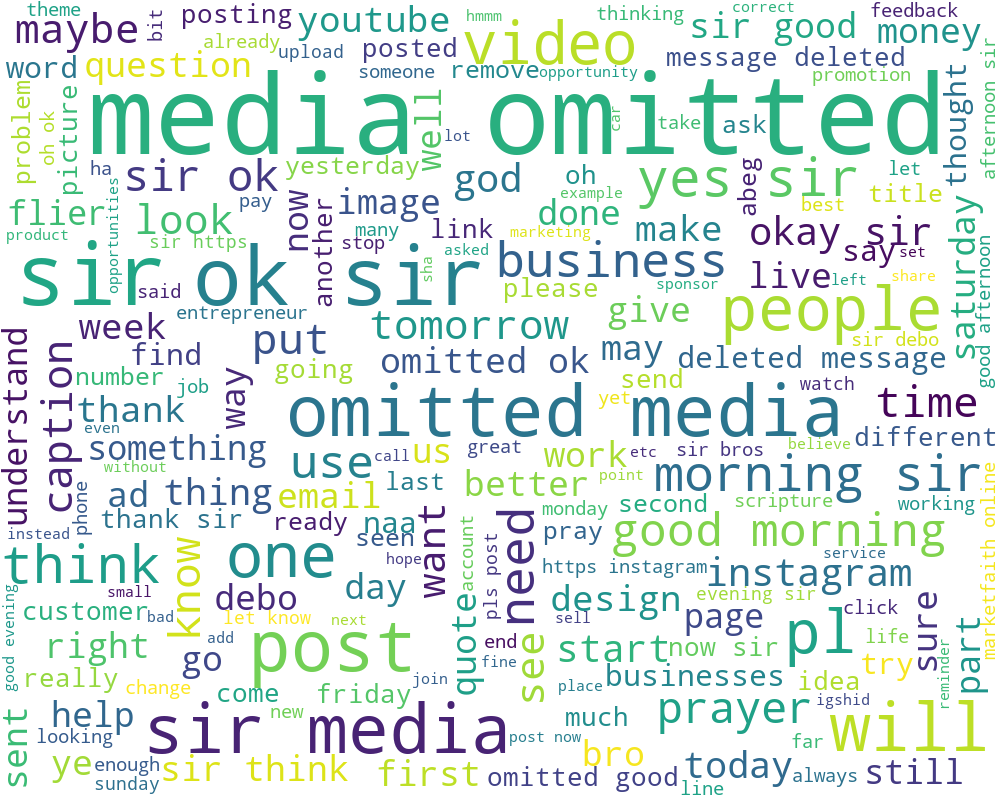

In [135]:
wordcloud.to_image()